In [133]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random


def make_graph(G):

    # Convertendo o grafo para direcionado caso não seja
    if not nx.is_directed(G):
        print('O grafo está sendo convertido para direcionado..')
        G = G.to_directed()    

    # Renomeando os nós
    n_unique_nodes = len(set(G.nodes()))
    node2int = dict(zip(set(G.nodes()), range(n_unique_nodes)))
    int2node = {v:k for k,v in node2int.items()}

    G = nx.relabel_nodes(G, node2int)

    # salvando a label original dos nós como o atributo 'label'
    for node in G.nodes():
        G.nodes[node]['label'] = int2node[node]

    # Removendo nós isolados
    nodes = G.nodes()
    for node in nodes:
        if len(G.edges(node))==0:
            G.remove_node(node)
    return G, int2node       

In [134]:
def plot_graph(G, final_probs, int2node, bool_final_probs=False):
    
    # plot_graph_pyvis(G, final_probs, int2node, bool_final_probs)

    # obtendo a label e pagerank de cada nó
    labels = {}
    pageranks = []
    probs = []
    for node in G.nodes():
        labels[node] = G.nodes[node]['label']
        pageranks.append(G.nodes[node]['pagerank'])

    try:
        clubs = np.array(list(map(lambda x: G.nodes[x]['club'], G.nodes())))
        # labels = dict(zip(G.nodes(), clubs)) 
    except:
        pass   


    
    pos = nx.spring_layout(G, k=2)  # k regulates the distance between nodes

    # ploting curvy edges
    nx.draw_networkx_edges(
        G, pos, arrows=True, arrowstyle="->", arrowsize=10, alpha=0.3,
        connectionstyle="arc3,rad=0.1"
    )

    font_size = 10
    node_size = 600

    if not bool_final_probs:
        nx.draw_networkx_nodes(G, pos, node_size=node_size, alpha=0.8)
        nx.draw_networkx_labels(G, pos, labels, font_size=font_size)
        # nx.draw(G, with_labels=True, alpha=0.8, arrows=False, labels=labels)
    else:
        # nx.draw(G, with_labels=True, alpha=0.8, arrows=False, node_color = pageranks, \
        #                                                                                 cmap=plt.get_cmap('Purples'), labels=labels)
        nx.draw_networkx_nodes(G, pos, node_size=node_size,
                alpha=0.8, node_color = pageranks, cmap=plt.get_cmap('Purples'))
        nx.draw_networkx_labels(G, pos, labels, font_size=font_size)

        # Adicionando a barra de cores com os valores de ranking
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('Purples'), norm=plt.Normalize(vmin = min(pageranks), vmax=max(pageranks)))
        sm._A = []
        plt.colorbar(sm)
    return plt

In [136]:
# from pyvis.network import Network

# def plot_graph_pyvis(G, final_probs, int2node, bool_final_probs=False, layout="spring"):
#     # Criando uma instância do objeto Network
#     net = Network(notebook=True, cdn_resources="remote")
#     labels = int2node

#     net.from_nx(G)

#     # Ajustando o layout
#     if layout == "spring":
#         net.force_atlas_2based()
#     elif layout == "circular":
#         net.layout_circular()

#     # pintando os nós conforme o ranking
#     cmap = plt.get_cmap('viridis')

#     try:
#         for node, prob in zip(net.nodes, final_probs):
#             node['value'] = prob
#             node['title'] = f"PageRank: {prob:.3f}, {cmap(prob)}"
#             node['color'] = cmap(prob)

#             # salvando o arquivo
#             net.show_buttons()
#             # net.show("colored_graph.html")
#     except:
#         net.show_buttons()
#         # net.show("colored_graph.html")


    

    


# # Exemplo de uso:
# # plot_graph_pyvis(G, final_probs, int2node, bool_final_probs=True)


In [137]:
def make_pagerank_matrix(G, d):
    n_nodes = len(G.nodes())

    # Construindo matriz de adjacência
    adj_matrix = np.zeros(shape=(n_nodes, n_nodes))

    for edge in G.edges():
        adj_matrix[edge[0], edge[1]] = 1

    # Construindo a matriz P de probabilidade de transição entre os nós
    tran_matrix = adj_matrix / np.sum(adj_matrix, axis=1).reshape(-1,1)

    # Construindo a matriz de navegação aleatória, onde todos os nós tem a mesma probabilidade de serem visitados
    random_surf = np.ones(shape = (n_nodes, n_nodes)) / n_nodes    

    # Construindo a matriz de transição para nós absorventes
    absorbing_nodes = np.zeros(shape = (n_nodes,))
    for node in G.nodes():
        if len(G.out_edges(node))==0:
            absorbing_nodes[node] = 1
    
    absorbing_node_matrix = np.outer(absorbing_nodes, np.ones(shape = (n_nodes,))) / n_nodes

    # Matriz estocástica
    stochastic_matrix = tran_matrix + absorbing_node_matrix

    # Matriz de transição modificada P' = d * P + (1-d) * [1]/n
    pagerank_matrix = d * stochastic_matrix + (1-d) * random_surf
    return pagerank_matrix

In [138]:
def random_walk(G, d, n_iter):

    n_nodes = len(G.nodes())

    # Vetor inicial com probabilidades iguais para todos os nós
    initial_state = np.ones(shape=(n_nodes,)) / n_nodes
    pagerank_matrix = make_pagerank_matrix(G, d)

    new_initial_state = initial_state
    NORM = []
    for i in range(n_iter):
        final_state = np.dot(np.transpose(pagerank_matrix), new_initial_state)
        
        prev_initial_state = new_initial_state
        new_initial_state = final_state

        L2 = np.linalg.norm(new_initial_state-prev_initial_state)
        NORM.append(L2)

        if np.allclose(new_initial_state, prev_initial_state):
            print(f'Convergiu em {i+1} iterações.')
            break

    plt.figure(figsize=(8,4))
    plt.plot(range(i+1), NORM)
    plt.xlabel('Iterações')
    plt.ylabel('Norma Euclidiana')
    plt.title('Convergência do PageRank')
    plt.show()
    return final_state

In [139]:
def run(G, d, n_iter):
    # Encontrando o ranqueamento dos nós por meio do PageRank

    G, int2node = make_graph(G)
    ranks = {}

    final_probs = random_walk(G, d, n_iter)

    # Garantindo que as dimensões estão corretas
    assert len(final_probs) == len(G.nodes())

    # Garantindo que as probabilidades somam 1
    assert np.allclose(np.sum(final_probs), 1)
    
    # Printando o ranking dos nós com os nomes originais 
    print('PageRank:')
    for i in np.argsort(final_probs)[::-1]:
        ranks[int2node[i]] = final_probs[i]
        # print(f'{int2node[i]}: {final_probs[i]}')
        G.nodes[i]['pagerank'] = final_probs[i]

    # adicionando em cada nó o atributo 'pagerank'

    
    
    plt.figure(figsize=(40,10))
    plt.subplot(121)
    plot_graph(G, None, int2node, bool_final_probs=False)
    plt.figure(figsize=(40,10))
    plt.subplot(122)
    plot_graph(G, final_probs, int2node, bool_final_probs=True)
    plt.show()
    return ranks, G

O grafo está sendo convertido para direcionado..
Convergiu em 46 iterações.


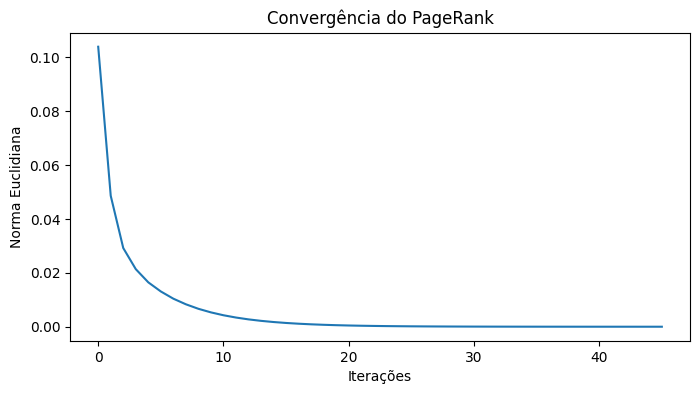

PageRank:


C:\Users\Cole\AppData\Local\Temp\ipykernel_5108\3587641093.py:46: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


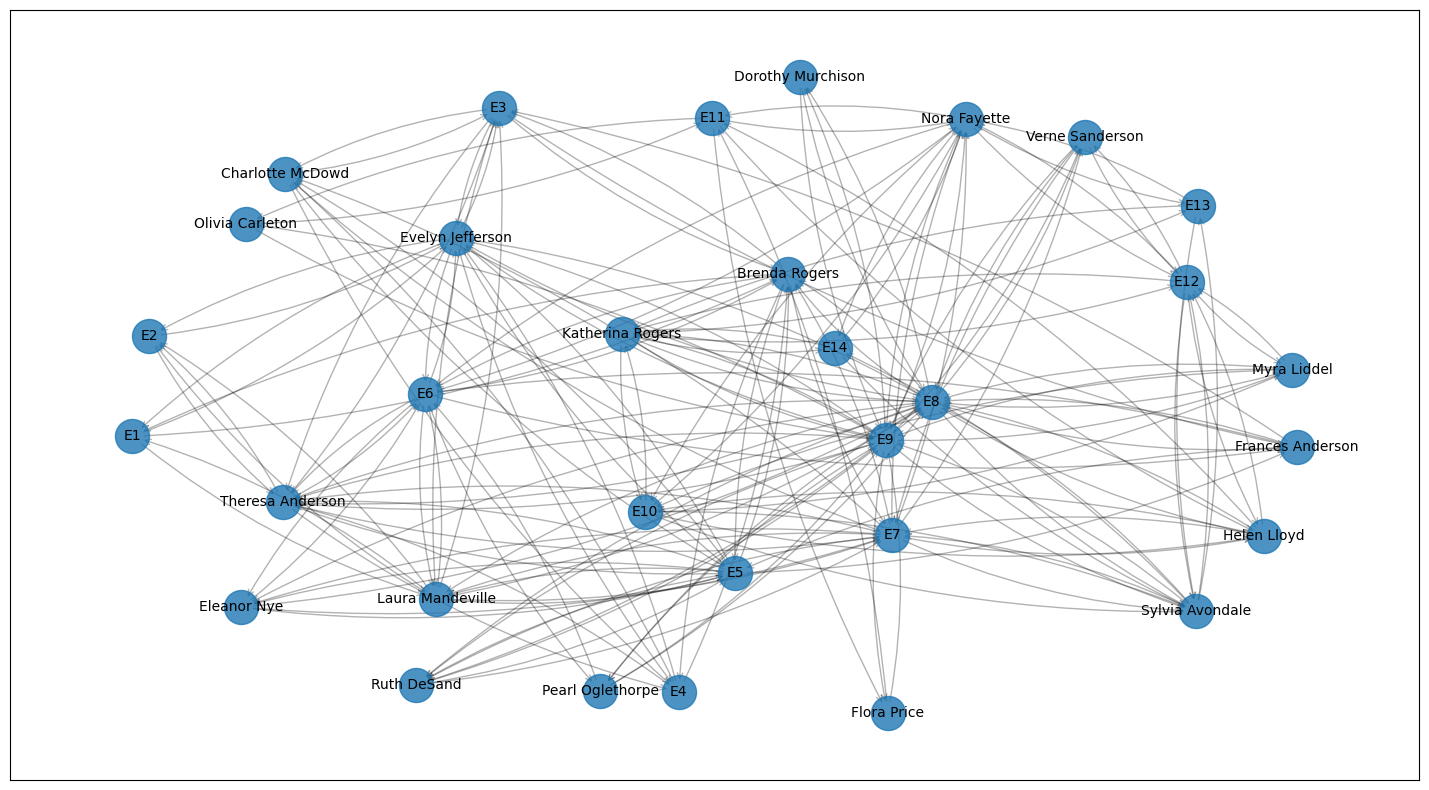

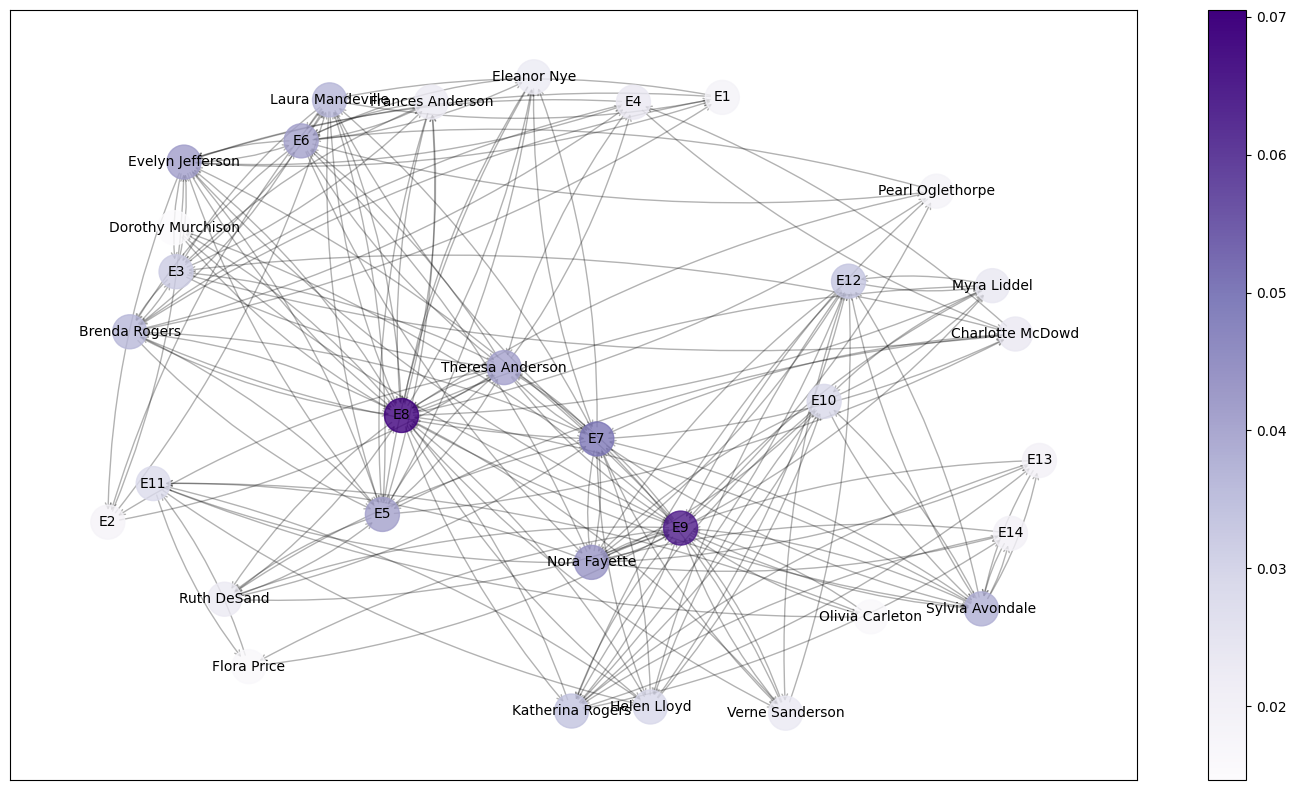

In [140]:
d = 0.8
n_iter = 1000

G = nx.davis_southern_women_graph()
ranks, G = run(G, d, n_iter)

In [141]:
print('PageRank:')
for node, prob in ranks.items():
    print(f'{node}: {prob}')


PageRank:
E8: 0.07048178085750612
E9: 0.06578724663582836
E7: 0.050601490871443534
Nora Fayette: 0.04408970153640634
Evelyn Jefferson: 0.0419367283625553
E6: 0.04145403970792619
E5: 0.04127687024295205
Theresa Anderson: 0.0409594323427314
Sylvia Avondale: 0.03829833012801641
Laura Mandeville: 0.036918677860351544
Brenda Rogers: 0.03659665174878216
Katherina Rogers: 0.03425017170678437
E12: 0.033662449488620516
E3: 0.03218930716945717
Helen Lloyd: 0.02913123038938351
E10: 0.029022498789880745
E11: 0.028367293101683077
Myra Liddel: 0.02379542978980348
E4: 0.02340157089081865
Charlotte McDowd: 0.023398184699383127
Verne Sanderson: 0.023199949252434227
Frances Anderson: 0.02284268555732649
Ruth DeSand: 0.02283930967716979
Eleanor Nye: 0.022598897204960156
E14: 0.01960249427339226
E13: 0.01960249427339226
E1: 0.01884530733772682
Pearl Oglethorpe: 0.018808868202611198
E2: 0.018758776086351524
Olivia Carleton: 0.0163093533668842
Flora Price: 0.0163093533668842
Dorothy Murchison: 0.01466342508

In [142]:
# Verificando se bate com o PageRank do NetworkX
ranking = nx.pagerank(G, alpha=0.8, max_iter=1000, tol=1e-06, nstart=None, weight='weight', dangling=None)

# ordenando o dicionário ranking pelos valores
ranking = {k: v for k, v in sorted(ranking.items(), key=lambda item: item[1], reverse=True)}

# Print formatado do ranking com os nomes originais, utilizando G.nodes()
print('PageRank do NetworkX:')
for node, prob in ranking.items():
    print(f'{G.nodes[node]["label"]}: {prob}')



PageRank do NetworkX:
E8: 0.07048301466577792
E9: 0.06578830421430404
E7: 0.05060237215896214
Nora Fayette: 0.04408899649828846
Evelyn Jefferson: 0.041936023331417195
E6: 0.04145474472253753
E5: 0.04127757524674804
Theresa Anderson: 0.040958727310985224
Sylvia Avondale: 0.03829771321965878
Laura Mandeville: 0.03691806095826376
Brenda Rogers: 0.03659603484674032
Katherina Rogers: 0.034249642927651626
E12: 0.033662978291091314
E3: 0.032189835918353664
Helen Lloyd: 0.029130789740726505
E10: 0.029022939460666537
E11: 0.028367645640127663
Myra Liddel: 0.023795077270838055
E4: 0.023401923390079325
Charlotte McDowd: 0.02339783218417768
Verne Sanderson: 0.02319959673429008
Frances Anderson: 0.022842333041753097
Ruth DeSand: 0.02283895716028227
Eleanor Nye: 0.022598544688788764
E13: 0.01960275867660418
E14: 0.01960275867660418
E1: 0.018845571711976164
Pearl Oglethorpe: 0.018808603814743155
E2: 0.018759040461704103
Olivia Carleton: 0.016309177107120577
Flora Price: 0.016309177107120577
Dorothy M

O grafo está sendo convertido para direcionado..
Convergiu em 32 iterações.


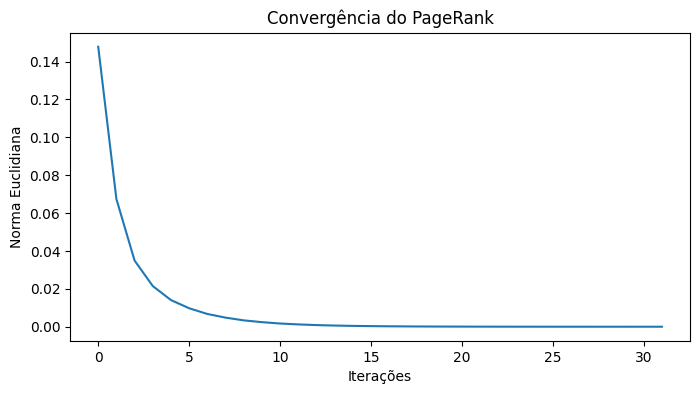

PageRank:


C:\Users\Cole\AppData\Local\Temp\ipykernel_5108\3587641093.py:46: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


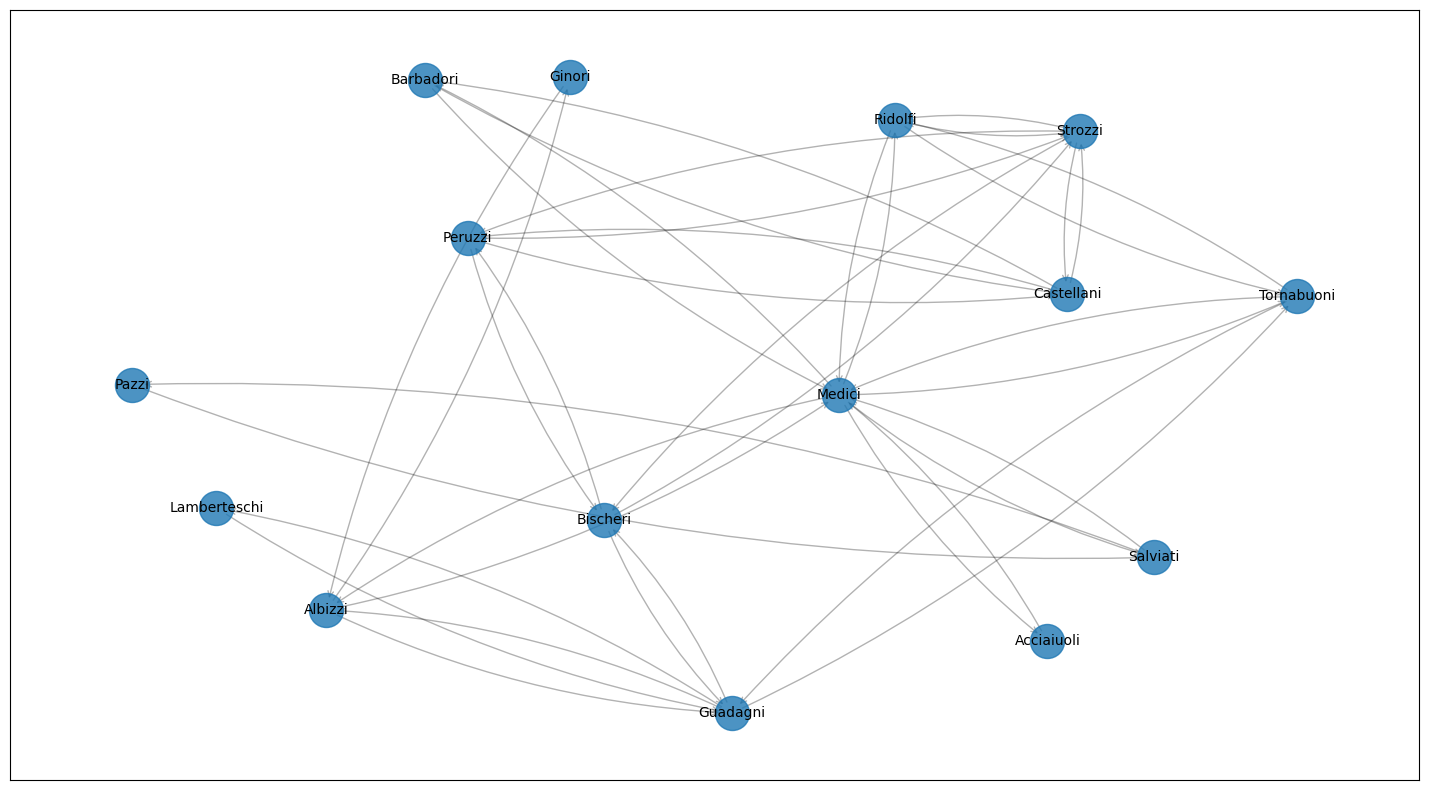

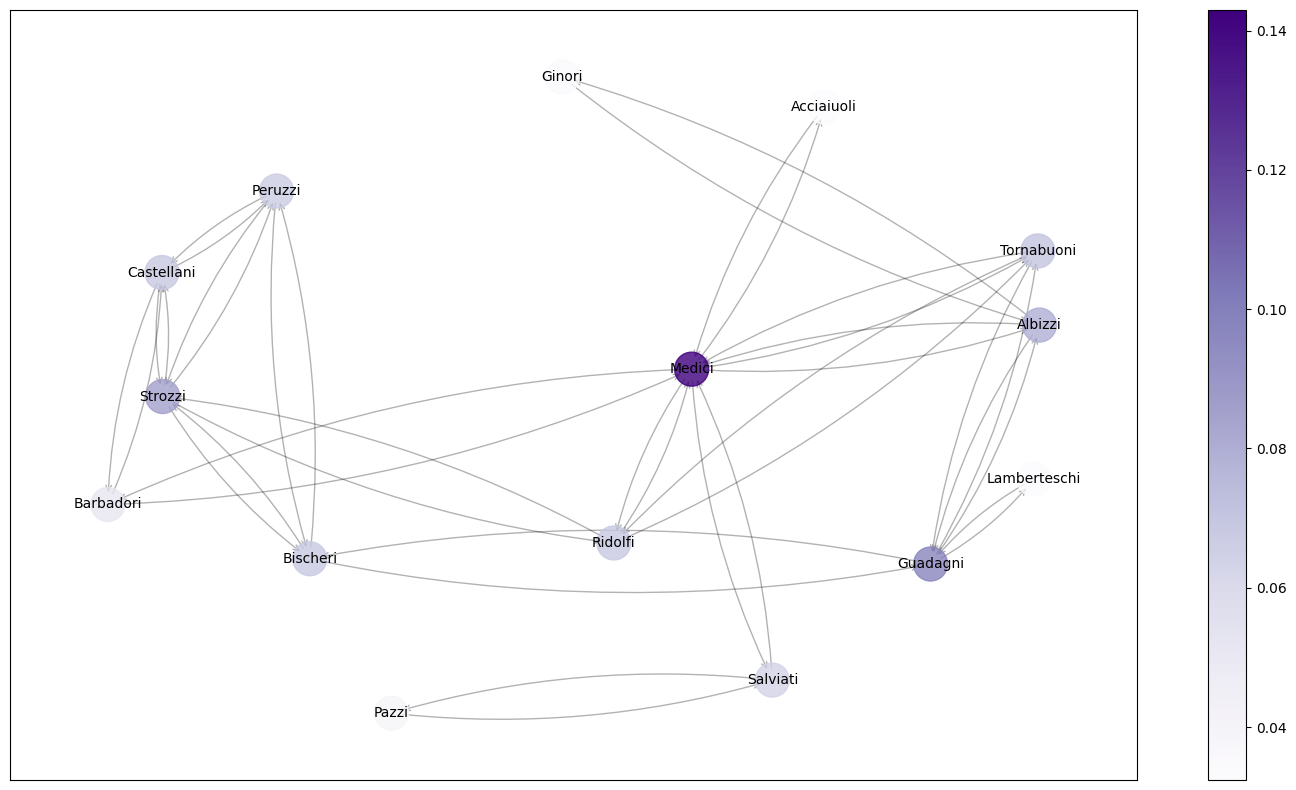

In [143]:
G2 = nx.florentine_families_graph()
ranks, G2 = run(G2, d, n_iter)

In [146]:
# Pagerank 
print('PageRank:')
for node, prob in ranks.items():
    print(f'{node}: {prob}')

PageRank:
Medici: 0.14296513752634
Guadagni: 0.0976224677546732
Strozzi: 0.08573840106139054
Albizzi: 0.07955949469126547
Tornabuoni: 0.07011770312120266
Castellani: 0.06858391368912006
Ridolfi: 0.06824113770516096
Bischeri: 0.06783478964556112
Peruzzi: 0.06685931815502866
Salviati: 0.06332677049591044
Barbadori: 0.05068454313740499
Pazzi: 0.03866385896410822
Ginori: 0.034549045039561035
Lamberteschi: 0.03285794357648438
Acciaiuoli: 0.03239547543678639


In [144]:
# Verificando se bate com o PageRank do NetworkX
ranking = nx.pagerank(G2, alpha=0.8, max_iter=1000, tol=1e-06, nstart=None, weight='weight', dangling=None)

# ordenando o dicionário ranking pelos valores
ranking = {k: v for k, v in sorted(ranking.items(), key=lambda item: item[1], reverse=True)}

# Print formatado do ranking com os nomes originais, utilizando G.nodes()
print('PageRank do NetworkX:')
for node, prob in ranking.items():
    print(f'{G2.nodes[node]["label"]}: {prob}')


PageRank do NetworkX:
Medici: 0.1429665982859834
Guadagni: 0.09762337764397065
Strozzi: 0.0857384663543674
Albizzi: 0.07955860172303533
Tornabuoni: 0.07011722466704556
Castellani: 0.0685840435238438
Ridolfi: 0.06824102510414301
Bischeri: 0.06783448428660845
Peruzzi: 0.06685933101651127
Salviati: 0.0633260733069229
Barbadori: 0.05068421893938917
Pazzi: 0.038664271610373
Ginori: 0.03454938471709383
Lamberteschi: 0.032857687558090175
Acciaiuoli: 0.03239521126262207
